In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sps

from LinearRegression import linear_regression_loss, linear_regression_gradient
from LogisticRegression import logistic_regression_loss, logistic_regression_gradient

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from functools import partial

In [2]:
import importlib
import methods
importlib.reload(methods)
from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState

In [58]:
from IPython.display import clear_output
import numpy as np
from functools import partial

def run_optimization_methods(w, data, time_distributions, loss_function,\
                             gradient_function, n_workers, batch_sizes, compressions,\
                             range_of_k, n_iterations, lr, model=None, criterion=None):
    times = dict()
    losses = dict()

    for compression in compressions:
        for compression_rate in range_of_k:
            if model and criterion:
                minibatch_sgd = MinibatchSGD(w, data, time_distributions, partial(loss_function, model=model, criterion=criterion),
                                             [partial(gradient_function, model=model, criterion=criterion, batch_size=batch_sizes[i])\
                                              for i in range(n_workers)],
                                             learning_rate=lr,
                                             compression_flag=compression, compression_size=compression_rate)
                async_gd = AsynchronousGD(w, data, time_distributions, partial(loss_function, model=model, criterion=criterion),
                                          [partial(gradient_function, model=model, criterion=criterion, batch_size=batch_sizes[i])\
                                           for i in range(n_workers)],
                                          learning_rate=lr,
                                          compression_flag=compression, compression_size=compression_rate)
                rennala_sgd = RennalaSGD(w, data, time_distributions, partial(loss_function, model=model, criterion=criterion),
                                          [partial(gradient_function, model=model, criterion=criterion, batch_size=batch_sizes[i])\
                                           for i in range(n_workers)],
                                          learning_rate=lr,
                                          compression_flag=compression, compression_size=compression_rate)
                rennala_sgd.set_batch_size(4)
            else:
                minibatch_sgd = MinibatchSGD(w, data, time_distributions, loss_function,
                                             [partial(gradient_function, batch_size=batch_sizes[i]) for i in range(n_workers)],
                                             learning_rate=lr,
                                             compression_flag=compression, compression_size=compression_rate)
                async_gd = AsynchronousGD(w, data, time_distributions, loss_function,
                                          [partial(gradient_function, batch_size=batch_sizes[i]) for i in range(n_workers)],
                                          learning_rate=lr,
                                          compression_flag=compression, compression_size=compression_rate)
                rennala_sgd = RennalaSGD(w, data, time_distributions, loss_function,
                                          [partial(gradient_function, batch_size=batch_sizes[i]) for i in range(n_workers)],
                                          learning_rate=lr,
                                          compression_flag=compression, compression_size=compression_rate)
                rennala_sgd.set_batch_size(4)

            methods = {'Minibatch SGD': minibatch_sgd,
                       'Async GD': async_gd,
                       'Rennala SGD': rennala_sgd}

            for method_name in methods:
                if method_name not in times:
                    times[method_name] = dict()
                if method_name not in losses:
                    losses[method_name] = dict()
                if compression not in times[method_name]:
                    times[method_name][compression] = dict()
                if compression not in losses[method_name]:
                    losses[method_name][compression] = dict()

                w = np.zeros(w.shape[0])
                print(f"Running {method_name} with compression {compression} and compression rate {compression_rate}")
                current_x, loss_history, computation_times, x_history = methods[method_name].run_steps(n_iterations)
                times[method_name][compression][compression_rate] = computation_times
                losses[method_name][compression][compression_rate] = loss_history

                # Clear output every 5 iterations
                if (compression_rate + 1) % 5 == 0:
                    clear_output(wait=True)
                    print(f"Cleared output after {compression_rate + 1} iterations")

    return times, losses, methods

In [59]:
from sklearn.datasets import make_regression
import numpy as np

X, y = make_regression(
    n_samples=300,
    n_features=100,
    n_informative=90,
    noise=3,
    random_state=42
)

X = np.hstack((X, np.ones((len(X), 1))))

In [60]:
n_workers = 4
time_distributions = [sps.norm(i+1, scale=1) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10
n_iterations = 2_000
lr = 1e-3

In [61]:
range_of_k = np.array(np.array([.01, .05, .1, .2]) * X.shape[1], dtype='int')
compressions = [#'none', 
                'randk',
                'topk',
                ]
range_of_k

array([ 1,  5, 10, 20])

## Linear regression

In [62]:
w = np.zeros(X.shape[1])
times_lin_regression, losses_lin_regression, methods = run_optimization_methods(w, (X, y), time_distributions,\
                                         linear_regression_loss, linear_regression_gradient,\
                                         n_workers, batch_sizes, compressions, range_of_k,\
                                         n_iterations, lr)

Running Minibatch SGD with compression randk and compression rate 1
Running Async GD with compression randk and compression rate 1
Running Rennala SGD with compression randk and compression rate 1
Running Minibatch SGD with compression randk and compression rate 5
Running Async GD with compression randk and compression rate 5
Running Rennala SGD with compression randk and compression rate 5
Running Minibatch SGD with compression randk and compression rate 10
Running Async GD with compression randk and compression rate 10
Running Rennala SGD with compression randk and compression rate 10
Running Minibatch SGD with compression randk and compression rate 20
Running Async GD with compression randk and compression rate 20
Running Rennala SGD with compression randk and compression rate 20
Running Minibatch SGD with compression topk and compression rate 1
Running Async GD with compression topk and compression rate 1
Running Rennala SGD with compression topk and compression rate 1
Running Mini

In [63]:
title_fontsize = 15
fontsize = 25

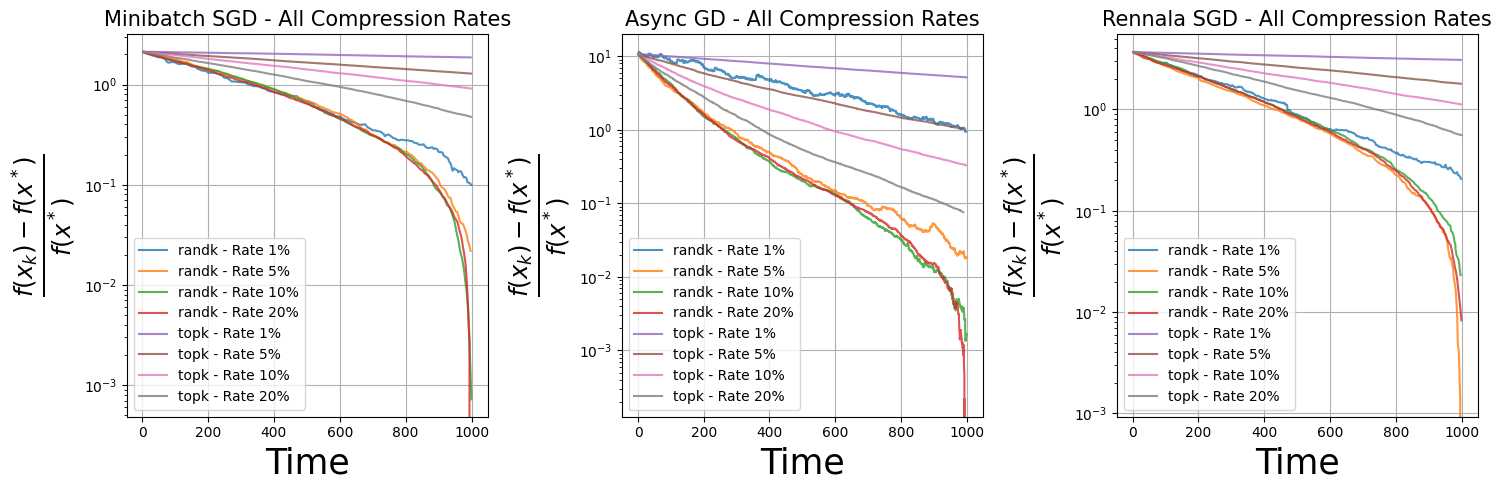

In [77]:
plt.figure(figsize=(15, 5))

MAX_TIME = 1000

compression_percentage = [1, 5, 10, 20]
# mn = min([np.min(losses_lin_regression[method_name][compression][compression_rate])for method_name in methods for compression in compressions for compression_rate in range_of_k])
# mn = 1e18

# for method_idx, method_name in enumerate(methods):
#     for compression in compressions:
#         for compression_rate in range_of_k:
#             ind = np.searchsorted(times_lin_regression[method_name][compression][compression_rate], MAX_TIME)
#             mn = min(mn, np.min(losses_lin_regression[method_name][compression][compression_rate][:ind]))
for method_idx, method_name in enumerate(methods):
    mn = 1e18
    for compression in compressions:
        for compression_rate in range_of_k:
            ind = np.searchsorted(times_lin_regression[method_name][compression][compression_rate], MAX_TIME)
            mn = min(mn, np.min(losses_lin_regression[method_name][compression][compression_rate][:ind]))
    plt.subplot(1, len(methods), method_idx + 1)
    for compression in compressions:
        i = 0
        for compression_rate in range_of_k:
            if compression in times_lin_regression[method_name] and compression_rate in times_lin_regression[method_name][compression]:
                ind = np.searchsorted(times_lin_regression[method_name][compression][compression_rate], MAX_TIME)
                discrepancy = losses_lin_regression[method_name][compression][compression_rate][:ind] -\
                                mn
                # print(discrepancy[-1])
                
                plt.plot(times_lin_regression[method_name][compression][compression_rate][:ind], \
                         discrepancy / mn, \
                         label=f'{compression} - Rate {compression_rate}%',\
                         alpha=.8)
            i += 1
    plt.title(f'{method_name} - All Compression Rates', fontsize=title_fontsize)
    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('$\\frac{f(x_k) - f(x^*)}{f(x^*)}$', fontsize=fontsize)
    plt.yscale('log')
    # plt.ylim(1e-4, 1e2)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Logistic regression


In [85]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("prishasawhney/mushroom-dataset")

data = pd.read_csv(f"{path}/mushroom_cleaned.csv")

scaler = MinMaxScaler()

x = data.drop('class', axis=1).values
x = scaler.fit_transform(x)
y = 2*data['class'].values - 1

lr = 1e-2

In [86]:
range_of_k = np.array(np.array([.01, .05, .1, .2]) * x.shape[1], dtype='int')
compressions = [#'none', 
                #'randk',
                'topk',
                ]
range_of_k

array([0, 0, 0, 1])

In [87]:
w = np.zeros(x.shape[1])
times_log_regression, losses_log_regression, methods = run_optimization_methods(w, (x, y), time_distributions,\
                                         logistic_regression_loss, logistic_regression_gradient,\
                                         n_workers, batch_sizes, compressions, range_of_k,\
                                         n_iterations, lr)

Running Minibatch SGD with compression topk and compression rate 0


KeyboardInterrupt: 

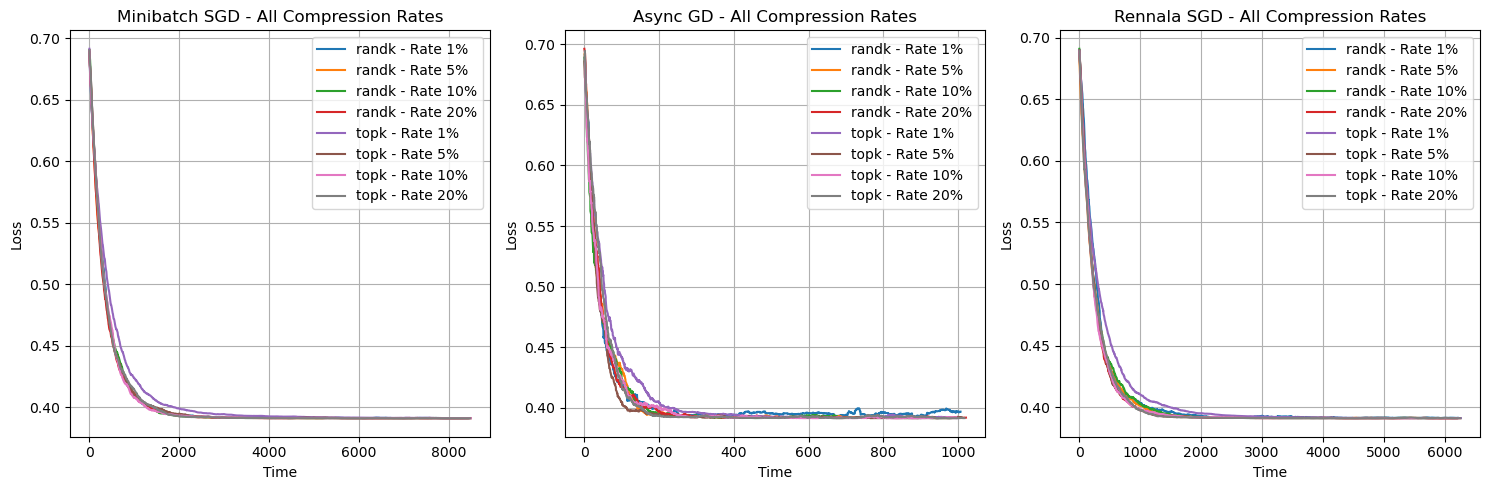

In [ ]:
plt.figure(figsize=(15, 5))

compression_percentage = [1, 5, 10, 20]

for method_idx, method_name in enumerate(methods):
    plt.subplot(1, len(methods), method_idx + 1)
    for compression in compressions:
        i = 0
        for compression_rate in range_of_k:
            if compression in times_log_regression[method_name] and compression_rate in times_log_regression[method_name][compression]:
                plt.plot(times_log_regression[method_name][compression][compression_rate], \
                         losses_log_regression[method_name][compression][compression_rate], \
                         label=f'{compression} - Rate {compression_percentage[i]}%')
            i += 1
    plt.title(f'{method_name} - All Compression Rates')
    plt.xlabel('Time')
    plt.ylabel('Loss')
    #plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Simple NN

In [3]:
def load_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5, std 0.5
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    return train_dataset, test_dataset

mnist_train, mnist_test = load_mnist()

In [4]:
import MLP_mnist
import importlib
importlib.reload(MLP_mnist)
import methods
importlib.reload(methods)
from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState
from MLP_mnist import SimpleNN, loss_from_vector, gradient_from_vector
model = SimpleNN()

In [5]:
k = 10
subset_indices = torch.randperm(len(mnist_train))[:k]
subset_train = torch.utils.data.Subset(mnist_train, subset_indices)
train_loader = DataLoader(subset_train, batch_size=64, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
num_param = sum(p.numel() for p in model.parameters())
n_iterations = 5
lr = 1e-2

In [15]:
range_of_k = np.array(np.array([.01, .05, .1, .2]) * len(mnist_train), dtype='int')

In [21]:
start = torch.rand((1, num_param))
minibatch_sgd = MinibatchSGD(start, mnist_train, time_distributions, partial(loss_from_vector, model=model, criterion=criterion), \
                              [partial(gradient_from_vector, model=model, criterion=criterion, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr, compression_flag='topk', compression_size=range_of_k[-1]
                                  )
method_name = 'Minibatch SGD'

In [22]:
times = dict()
losses = dict()
current_x, loss_history, computation_times, x_history = minibatch_sgd.run_steps(5)
times[method_name] = computation_times
losses[method_name] = loss_history

IndexError: index 8475 is out of bounds for axis 0 with size 1